## `Phân cụm sử dụng thuật toán K-Means Clustering để tìm ra các phân khúc khách hàng`

<img src="./image_gifs/customer_segmentation.gif">

Phân tích tính cách khách hàng giúp doanh nghiệp điều chỉnh sản phẩm của mình dựa trên các khách hàng mục tiêu thuộc các loại phân khúc khách hàng khác nhau. Ví dụ: thay vì chi tiền để tiếp thị sản phẩm mới tới mọi khách hàng trong cơ sở dữ liệu của công ty, công ty có thể phân tích phân khúc khách hàng nào có nhiều khả năng mua sản phẩm nhất và sau đó chỉ tiếp thị sản phẩm trên phân khúc cụ thể đó.

Phần quan trọng nhất của phân tích tính cách khách hàng là tìm ra câu trả lời cho các câu hỏi như: 
- Mọi người nói gì về sản phẩm đó: điều gì mang lại thái độ của khách hàng đối với sản phẩm. 
- Mọi người làm gì: tiết lộ những gì mọi người đang làm hơn là những gì họ đang nói về sản phẩm của bạn.

Trong Project này, chúng ta sẽ thực hiện một kỹ thuật học máy thuộc lớp không giám sát (Unsupervised learning) - Clustering. Kỹ thuật sử dụng sẽ là kỹ thuật phân cụm không phân cấp, cụ thể là sử dụng thuật toán K-Means

## 1, Nhập thư viện và dữ liệu

In [1]:
import numpy as np
import pandas as pd

import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA


from yellowbrick.cluster import KElbowVisualizer

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

raw_df = pd.read_csv('./data/marketing_campaign.csv', sep='\t')

## 2, Khám phá dữ liệu

In [2]:
# Số dòng và số cột của dữ liệu
print("Số dòng và cột của dữ liệu:", raw_df.shape)

Số dòng và cột của dữ liệu: (2240, 29)


In [3]:
# Kiểm tra xem dữ liệu có trùng lặp không
print("Số dòng dữ liệu trùng lặp:", raw_df.duplicated().sum())

Số dòng dữ liệu trùng lặp: 0


In [4]:
# Tên các cột của dữ liệu
raw_df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

<img src = "./image_gifs/image_columns.png">

Trong đó, gồm các thành phần chính sau:
- Thông tin khách hàng: 10 cột
    - ID: Mã định danh
    - Year_Birth: Năm sinh
    - Education: Trình độ học vấn
    - Marital_Status: Tình trạng hôn nhân
    - Income: Thu nhập hàng năm của hộ gia đình khách hàng
    - Kidhome: Số trẻ em trong hộ gia đình
    - Teenhome: Số thanh thiếu niên trong hộ gia đình
    - Dt_Customer: Ngày khách hàng bắt đầu sử dụng dịch vụ/sản phẩm của công ty
    - Recency: Số ngày kể từ lần mua hàng cuối cùng của khách hàng
    - Complain: Có hai giá trị: 1 nếu khách hàng có phàn nàn trong 2 năm qua, 0 nếu ngược lại

- Sản phẩm: 6 cột
    - MntWines: Số tiền chi cho rượu vang trong 2 năm qua
    - MntFruits: Số tiền chi cho trái cây trong 2 năm qua
    - MntMeatProducts: Số tiền chi cho thịt trong 2 năm qua
    - MntFishProducts: Số tiền chi cho cá trong 2 năm qua
    - MntSweetProducts: Số tiền chi cho đồ ngọt trong 2 năm qua
    - MntGoldProds: Số tiền chi cho vàng trong 2 năm qua

- Khuyến mãi: (Promotion) 7 cột
    - NumDealsPurchases: Số lần mua hàng được giảm giá
    - AcceptedCmp1: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 1, 0 nếu ngược lại
    - AcceptedCmp2: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 2, 0 nếu ngược lại
    - AcceptedCmp3: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 3, 0 nếu ngược lại
    - AcceptedCmp4: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 4, 0 nếu ngược lại
    - AcceptedCmp5: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 5, 0 nếu ngược lại
    - Response: 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch trước, 0 nếu ngược lại

- Place: 4 cột
    - NumWebPurchases: Số lần KH mua hàng qua trang web của công ty
    - NumCatalogPurchases: Số lần mua hàng được thực hiện bằng danh mục
    - NumStorePurchases: Số lần mua hàng trực tiếp ở cửa hàng
    - NumWebVisitsMonth: Số lượng truy cập vào website của công ty trong tháng qua

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

`Nhận xét 1:`
- Trường Income có nulls với 2216/2240 dòng
- Trường Dt_customer chứa dữ liệu về ngày (date) mà khách hàng được thêm vào CSDL của công ty có kiểu dữ liệu là dtype=**object**
- Có một số đặc trưng (features) thuộc loại đặc trưng phân loại (categorical features), có thể nhận biết bằng kiểu dữ liệu dtype=**object** như **Education** và **Marital_Status**. Chúng ta sẽ cần mã hóa (encoding) chúng về dạng số để mô hình học máy có thể hiểu

In [6]:
# Xóa các dòng có giá trị null
processed_df = raw_df.dropna()
print("Số dòng và cột của dữ liệu sau khi xóa các dòng có giá trị trống:", processed_df.shape)

Số dòng và cột của dữ liệu sau khi xóa các dòng có giá trị trống: (2216, 29)


In [7]:
numeric_columns = ['Year_Birth', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

In [8]:
processed_df[numeric_columns].describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043
std,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000


`Nhận xét 2:`
- **Year_Birth**: năm sinh trung bình là 1969, min=1893 chứng tỏ đây có thể outlier (ngoại lai)
- **Income**: thu nhập trung bình là 52k, min=1730 max=666666 rất lớn và đây có thể là outlier
- **Kidhome và Teenhome**: KH trung bình có 1 con, min=0 max=4
- **Recency**: số ngày mua hàng gần nhất trung bình là 49 ngày, max=99 ngày
- **NumWebVisitsMonth**: Số lần truy cập vào website trung bình là 5 lần mỗi tháng, nhiều nhất là 20 lần

<Axes: >

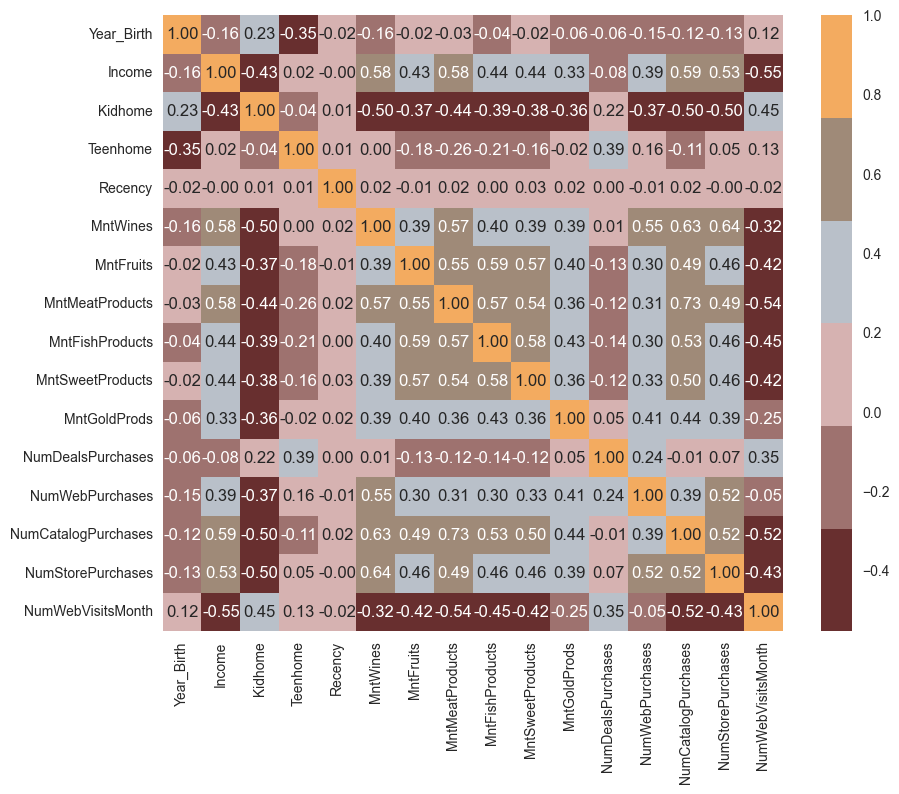

In [9]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Ma trận tương quan giữa các cột dữ liệu
plt.figure(figsize=(10,8))
sns.heatmap(processed_df[numeric_columns].corr(), annot=True, cmap=cmap, fmt=".2f")

## 3, Tiền xử lý dữ liệu

### 3.1 Bỏ các cột không sử dụng

- 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5' : Các cột này mô tả chiến dịch mà KH chấp nhận voucher, không có ý nghĩa khi phân cụm
- 'Z_Revenue', 'Z_CostContact' : Không có dữ liệu thực
- 'Complain', 'Response' : Các cột này cũng không có ý nghĩa khi phân cụm

In [10]:
columnList = ['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Z_Revenue', 'Z_CostContact', 'Complain']

processed_df = processed_df.drop(columns=columnList)

### 3.2 Dữ liệu dạng số liên tục (Continuous numeric data)

In [11]:
# Tính toán thời gian gần đây nhất một KH được thêm vào database của công ty
processed_df['Dt_Customer'] = pd.to_datetime(processed_df['Dt_Customer'], format='%d-%m-%Y')
max_year = processed_df['Dt_Customer'].dt.year.max()
print("Năm gần đây nhất:", max_year)

Năm gần đây nhất: 2014


In [12]:
# Từ cột 'Year_Birth' tạo ra feature mới là 'Age', lấy giá trị ở trên trừ đi năm sinh của KH
processed_df['Age'] = max_year - processed_df['Year_Birth']

# Xoá cột 'Year_Birth' vì không cần thiết nữa
processed_df = processed_df.drop(columns=['Year_Birth'])

Như ở trong bước **Khám phá dữ liệu**, ta thấy có một số điểm dữ liệu bất thường như: năm sinh là 1893, income là 666666 và đó có thể là các outliers cần được loại bỏ. Ta sẽ sử dụng biểu đồ **Scatter** để trực quan các điểm dữ liệu bất thường đó

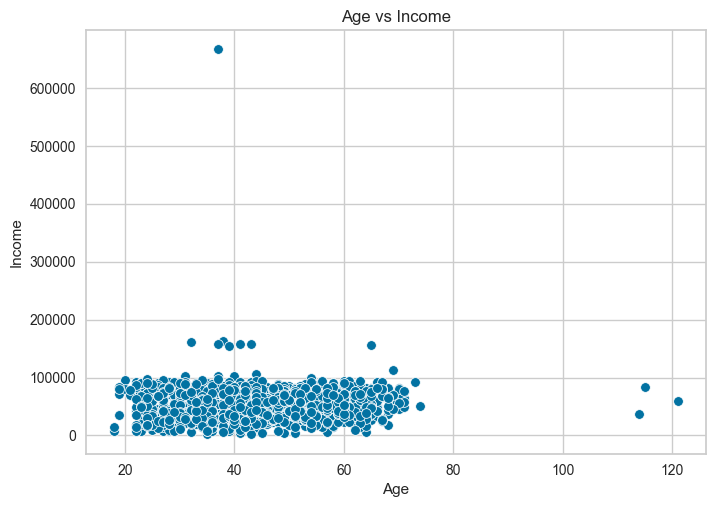

In [13]:
# Trực quan hóa dữ liệu Age và Income
sns.scatterplot(x='Age', y='Income', data=processed_df)

# Đặt tên và nhãn
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')

plt.show()

`Nhận xét:` Nhìn vào biểu đồ, ta thấy có 1 outlier ở **Income** và 3 outliers ở **Age**

In [14]:
# Xử lý outliers
processed_df = processed_df[processed_df['Income'] <= 200000]
processed_df = processed_df[processed_df['Age'] <= 100]
print("Số dòng và cột sau khi loại bỏ outliers:", processed_df.shape)

Số dòng và cột sau khi loại bỏ outliers: (2212, 19)


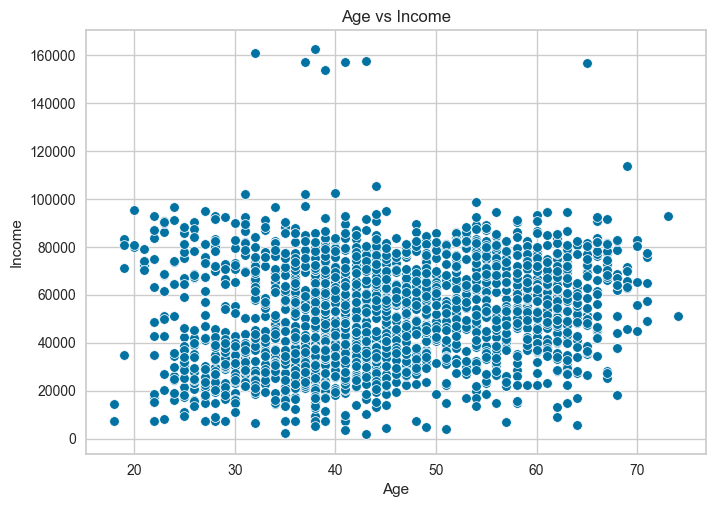

In [15]:
# Dữ liệu sau khi xử lý outliers
sns.scatterplot(x='Age', y='Income', data=processed_df)

# Đặt tên và nhãn
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')

plt.show()

In [16]:
# Gộp kidhome và teenhome thành một feature mới là Children tổng số con cái trong hộ gia đình
processed_df['Children'] = processed_df['Kidhome'] + processed_df['Teenhome']

processed_df = processed_df.drop(columns=['Kidhome', 'Teenhome'])

In [17]:
# Tạo feature mới tính số ngày một KH tham gia vào chương trình của công ty
min_date = processed_df['Dt_Customer'].min()
max_date = processed_df['Dt_Customer'].max()
print("Ngày đầu tiên tham gia:", min_date)
print("Ngày gần đây nhất tham gia:", max_date)

print("Khách hàng đầu tiên đã tham gia được:", (max_date - min_date).days, "ngày")

processed_df['CustomerFor'] = processed_df['Dt_Customer'].apply(lambda x: (max_date - x).days)

# Xoá cột 'Dt_Customer' vì không cần thiết nữa
processed_df = processed_df.drop(columns=['Dt_Customer'])

processed_df.head()

Ngày đầu tiên tham gia: 2012-07-30 00:00:00
Ngày gần đây nhất tham gia: 2014-06-29 00:00:00
Khách hàng đầu tiên đã tham gia được: 699 ngày


,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,CustomerFor
0,Graduation,Single,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,57,0,663
1,Graduation,Single,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,60,2,113
2,Graduation,Together,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,49,0,312
3,Graduation,Together,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,30,1,139
4,PhD,Married,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,33,1,161


In [18]:
Mn_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
processed_df[Mn_columns].head()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,635,88,546,172,88,88
1,11,1,6,2,1,6
2,426,49,127,111,21,42
3,11,4,20,10,3,5
4,173,43,118,46,27,15


In [19]:
processed_df

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,CustomerFor
0,Graduation,Single,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,57,0,663
1,Graduation,Single,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,60,2,113
2,Graduation,Together,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,49,0,312
3,Graduation,Together,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,30,1,139
4,PhD,Married,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,33,1,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Married,61223.0,46,709,43,182,42,118,247,2,9,3,4,5,47,1,381
2236,PhD,Together,64014.0,56,406,0,30,0,0,8,7,8,2,5,7,68,3,19
2237,Graduation,Divorced,56981.0,91,908,48,217,32,12,24,1,2,3,13,6,33,0,155
2238,Master,Together,69245.0,8,428,30,214,80,30,61,2,6,5,10,3,58,1,156


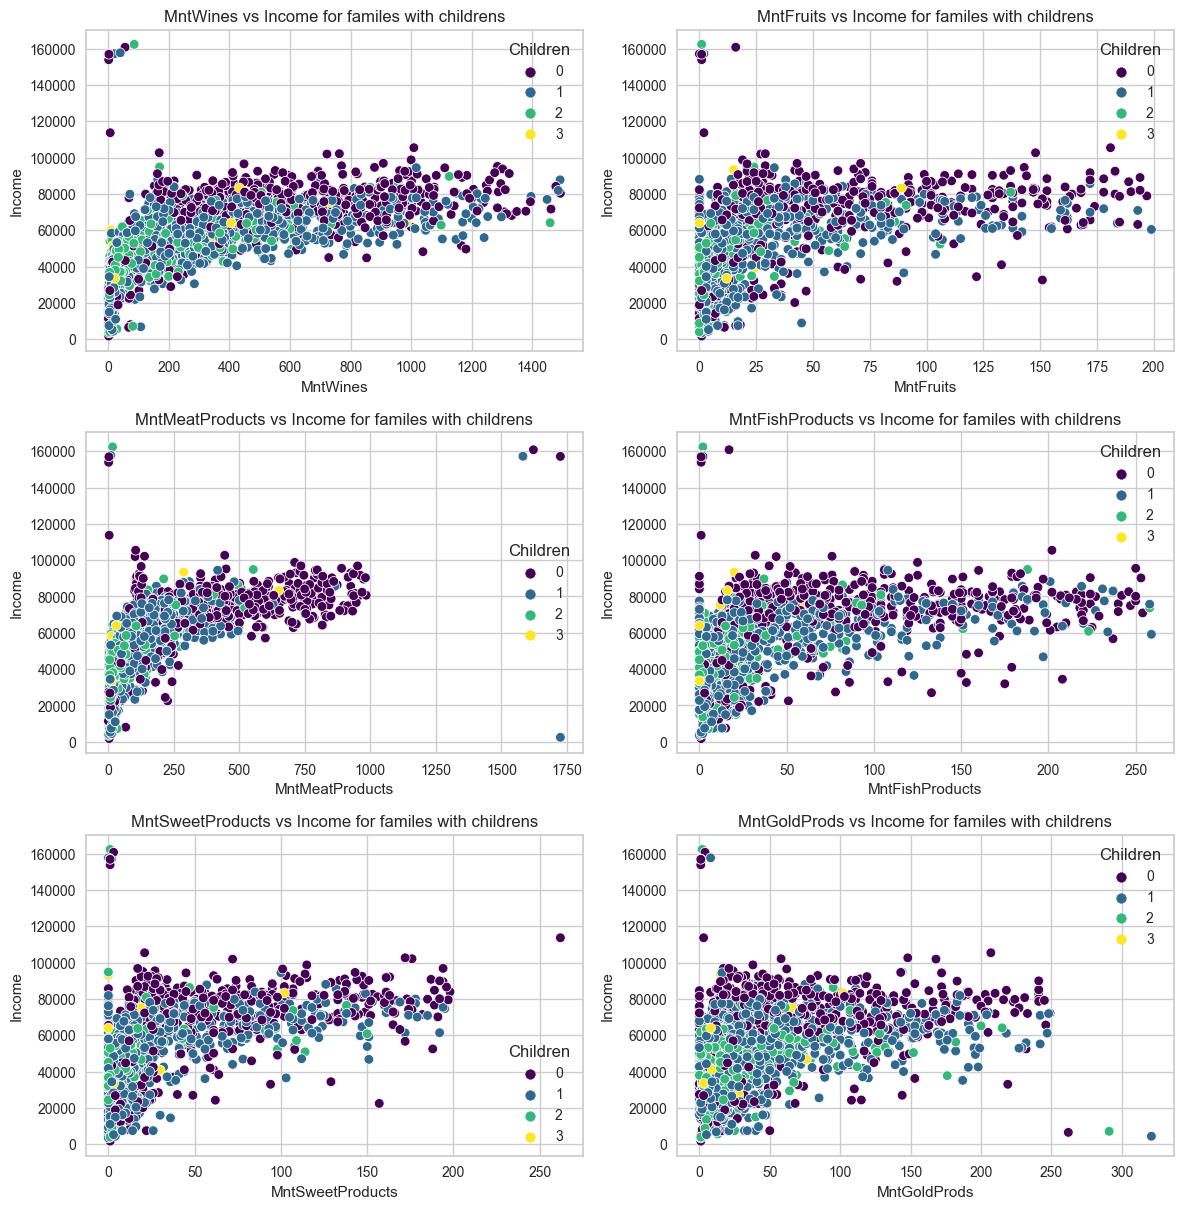

In [20]:
# Figure Settings
plt.subplots(figsize=(12, 40))

# Loop through each column in the list and plot graphs
for i, column in enumerate(processed_df[Mn_columns].columns):
    plt.subplot(len(processed_df.columns)//2 + 1, 2, i+1,)  # Create subplots
    sns.scatterplot(x= column , y='Income', hue="Children", data=processed_df, palette='viridis')
    plt.title(column + " vs Income for familes with childrens")
    plt.tight_layout()

# Show the plot
plt.show()

`Nhận xét:`
- Dữ liệu được chia làm 3 cụm
- KH có càng nhiều con thì lại càng chi tiêu ít đi chứng tỏ các sản phẩm/dịch vụ của công ty không phù hợp với những đối tượng này
- KH không có con chi tiêu nhiều tiền nhất trong tập các khách hàng và số lượng lớn là vào rượu vang và thịt

In [21]:
# Gộp các cột thành một feature mới là AmountSpent

processed_df['AmountSpent'] = processed_df['MntWines'] + processed_df['MntFruits'] + processed_df['MntMeatProducts'] + processed_df['MntFishProducts'] + processed_df['MntSweetProducts'] + processed_df['MntGoldProds']

raw_df2 = processed_df.copy()

processed_df = processed_df.drop(columns=Mn_columns)

<Axes: xlabel='AmountSpent', ylabel='Income'>

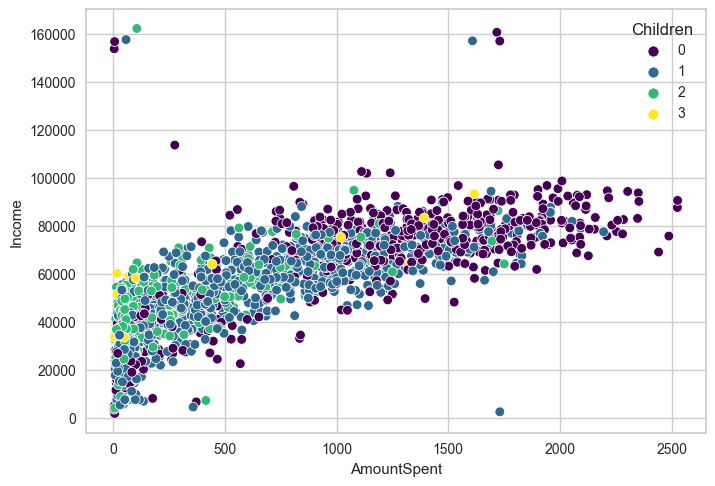

In [22]:
sns.scatterplot(x='AmountSpent', y='Income', hue='Children', data=processed_df, palette='viridis')

### 3.3 Dữ liệu dạng phân loại (Categorical data)

In [23]:
# Xem các giá trị có trong 'Education'
processed_df['Education'].value_counts()

Education
Graduation    1115
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: count, dtype: int64

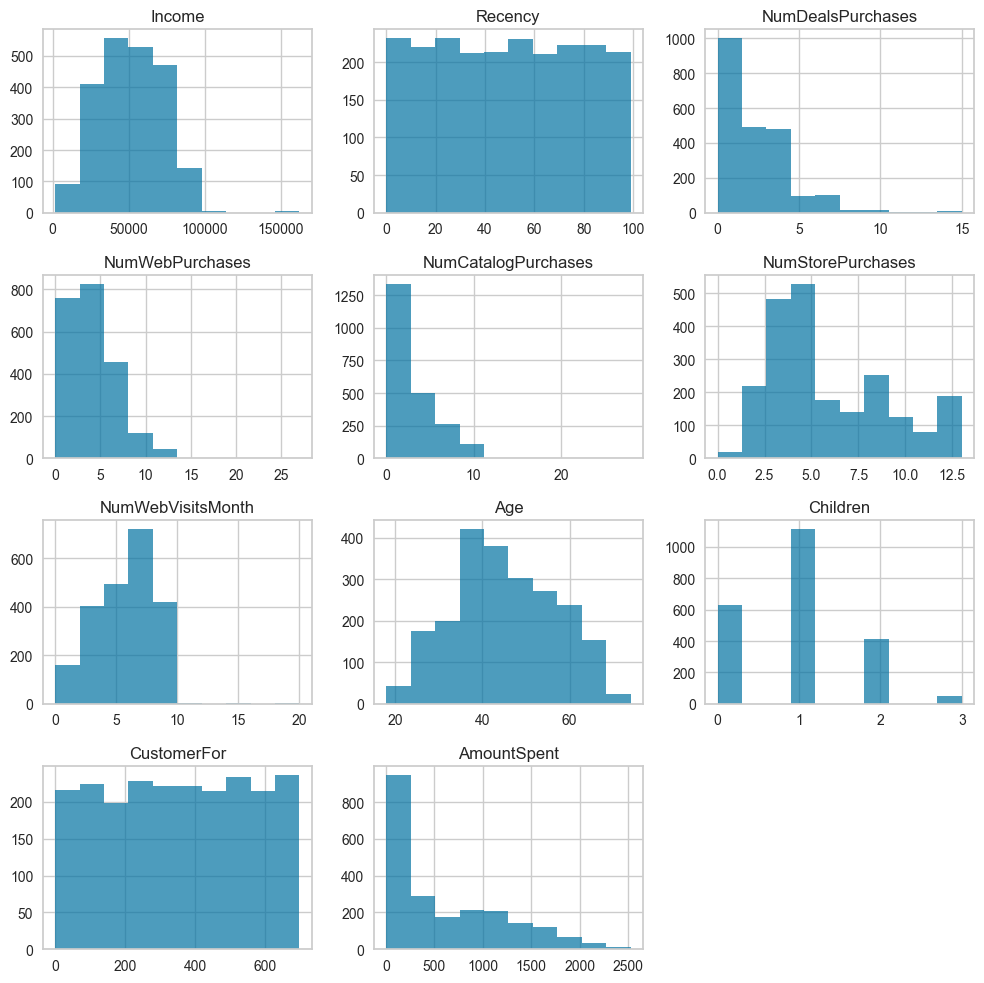

In [24]:
processed_df.hist(bins=10, figsize=(10,10), color='b', alpha=0.7)
plt.tight_layout()
plt.show()

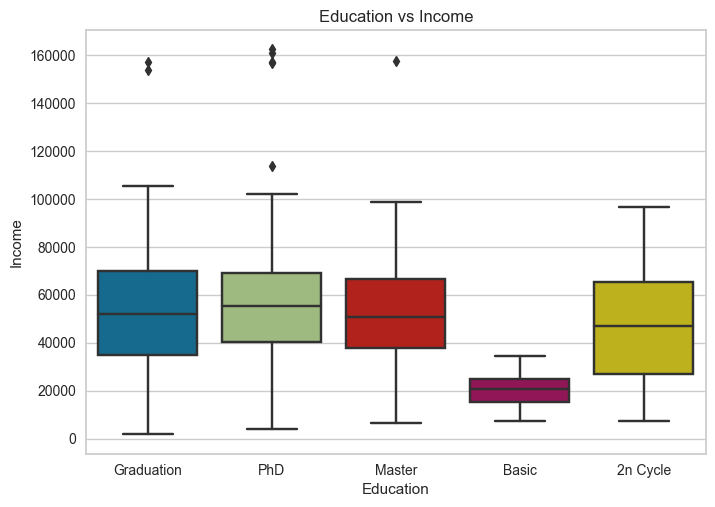

In [25]:
sns.boxplot(x='Education', y='Income', data=processed_df)

# Đặt tên và nhãn
plt.title('Education vs Income')
plt.xlabel('Education')
plt.ylabel('Income')

plt.show()

In [26]:
processed_df = processed_df.reset_index(drop=True)

Sử dụng kỹ thuật One-hot Encoding

In [27]:
ohe = OneHotEncoder()

# Số hóa dữ liệu
onehot_encoded = ohe.fit_transform(processed_df['Education'].values.reshape(-1, 1))
columns = ['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD']

edu_df = pd.DataFrame(onehot_encoded.toarray(), columns=columns)

processed_df = processed_df.drop(columns=['Education'])
# Gộp hai DataFrame theo cột (axis=1) hoặc hàng (axis=0)
processed_df = pd.concat([processed_df, edu_df], axis=1)  # Gộp theo cột
processed_df

,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,CustomerFor,AmountSpent,2n Cycle,Basic,Graduation,Master,PhD
0,Single,58138.0,58,3,8,10,4,7,57,0,663,1617,0.0,0.0,1.0,0.0,0.0
1,Single,46344.0,38,2,1,1,2,5,60,2,113,27,0.0,0.0,1.0,0.0,0.0
2,Together,71613.0,26,1,8,2,10,4,49,0,312,776,0.0,0.0,1.0,0.0,0.0
3,Together,26646.0,26,2,2,0,4,6,30,1,139,53,0.0,0.0,1.0,0.0,0.0
4,Married,58293.0,94,5,5,3,6,5,33,1,161,422,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,Married,61223.0,46,2,9,3,4,5,47,1,381,1341,0.0,0.0,1.0,0.0,0.0
2208,Together,64014.0,56,7,8,2,5,7,68,3,19,444,0.0,0.0,0.0,0.0,1.0
2209,Divorced,56981.0,91,1,2,3,13,6,33,0,155,1241,0.0,0.0,1.0,0.0,0.0
2210,Together,69245.0,8,2,6,5,10,3,58,1,156,843,0.0,0.0,0.0,1.0,0.0


Chuyển về dữ liệu phân loại nhị phân

Có tổng cộng 5 giá trị phân loại thuộc loại danh nghĩa (nominal) cho trình độ đại học, để đơn giản thì ta sẽ chia ra thành 2 trình độ: PostGrad và Non-PostGrad (sau đại học và không sau đại học)

In [28]:
# edu_dic = {'Graduation': 0, '2n Cycle': 0, 'Basic': 0, 'PhD': 1, 'Master': 1}
# processed_df['PostGrad'] = processed_df['Education'].replace(edu_dic)

# # Xóa cột 'Education' vì không cần thiết nữa
# processed_df = processed_df.drop(columns=['Education'])

# # Tạo biểu đồ KDE để trực quan hóa dữ liệu
# sns.kdeplot(x='Age', y='Income', hue="PostGrad", data=processed_df, palette={0: 'blue', 1: 'red'})

# # Set the title and labels
# plt.title('Income vs Age for PostGrad and Non-PostGrad peers')
# plt.xlabel('Age')
# plt.ylabel('Income')

# plt.show()

In [29]:
processed_df['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    571
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

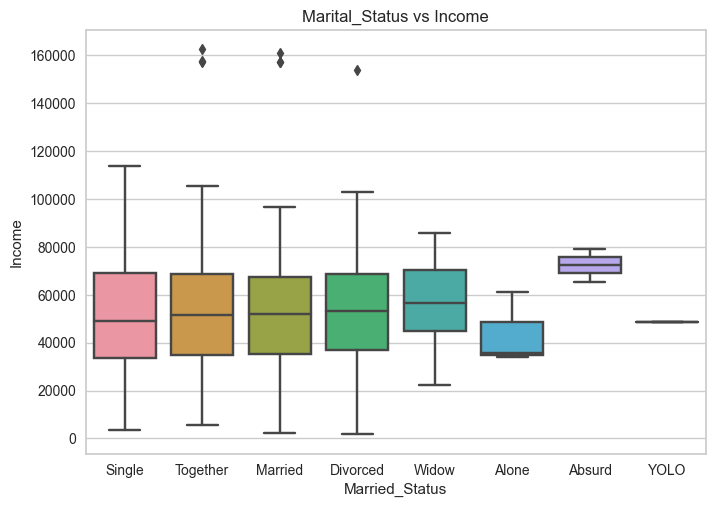

In [30]:
sns.boxplot(x='Marital_Status', y='Income', data=processed_df)

# Đặt tên và nhãn
plt.title('Marital_Status vs Income')
plt.xlabel('Married_Status')
plt.ylabel('Income')

plt.show()

Tương tự như trường **Education**, **Marital_Status** cũng là dữ liệu phân loại (nominal), để đơn giản chúng ta sẽ mã hóa dữ liệu như sau: 
- Together, Married = 1
- Single, Divorced, Widow, Alone, Absurd, YOLO = 0

Tạo feature mới là **Couple** chứa thông tin 

In [31]:
marital_dic = {'Single': 0, 'Divorced': 0, 'Widow': 0, 'Alone': 0, 'Absurd': 0, 'YOLO': 0, 'Married': 1, 'Together': 1}
processed_df['Couple'] = processed_df['Marital_Status'].replace(marital_dic)

# Xóa cột 'Marital_Status'
processed_df = processed_df.drop(columns=['Marital_Status'])

## 4, Khám phá dữ liệu sau tiền xử lý

In [32]:
print("Gồm các cột:", processed_df.columns)
print("Số dòng và cột của dữ liệu:", processed_df.shape)

Gồm các cột: Index(['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'Children', 'CustomerFor', 'AmountSpent', '2n Cycle', 'Basic',
       'Graduation', 'Master', 'PhD', 'Couple'],
      dtype='object')
Số dòng và cột của dữ liệu: (2212, 17)


In [33]:
processed_df.describe()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Children,CustomerFor,AmountSpent,2n Cycle,Basic,Graduation,Master,PhD,Couple
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,51958.810579,49.019439,2.324593,4.088156,2.672242,5.806510,5.321429,45.086347,0.947559,353.714286,607.268083,0.089512,0.024412,0.504069,0.165009,0.216998,0.645570
std,21527.278844,28.943121,1.924507,2.742187,2.927542,3.250939,2.425597,11.701599,0.749466,202.494886,602.513364,0.285546,0.154360,0.500096,0.371273,0.412295,0.478449
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35233.500000,24.000000,1.000000,2.000000,0.000000,3.000000,3.000000,37.000000,0.000000,180.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51371.000000,49.000000,2.000000,4.000000,2.000000,5.000000,6.000000,44.000000,1.000000,356.000000,397.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,68487.000000,74.000000,3.000000,6.000000,4.000000,8.000000,7.000000,55.000000,1.000000,529.000000,1048.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,162397.000000,99.000000,15.000000,27.000000,28.000000,13.000000,20.000000,74.000000,3.000000,699.000000,2525.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

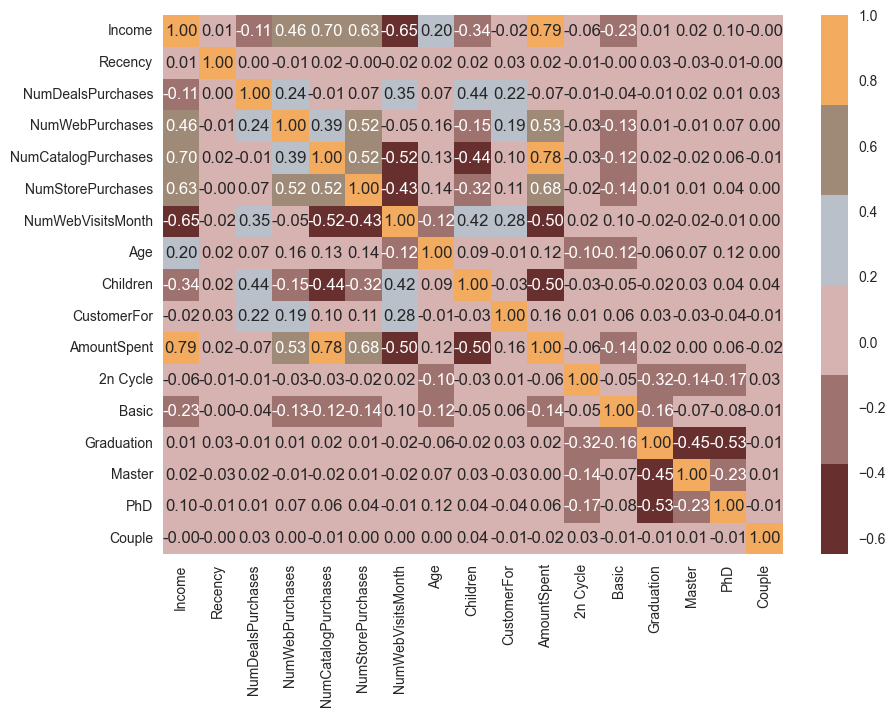

In [34]:
# Heatmap thể hiện mối tương quan giữa các feature
plt.figure(figsize=(10,7))
sns.heatmap(processed_df.corr(), annot=True, cmap=cmap, fmt='.2f')

## 5, Tiêu chuẩn hoá đặc trưng

<Axes: >

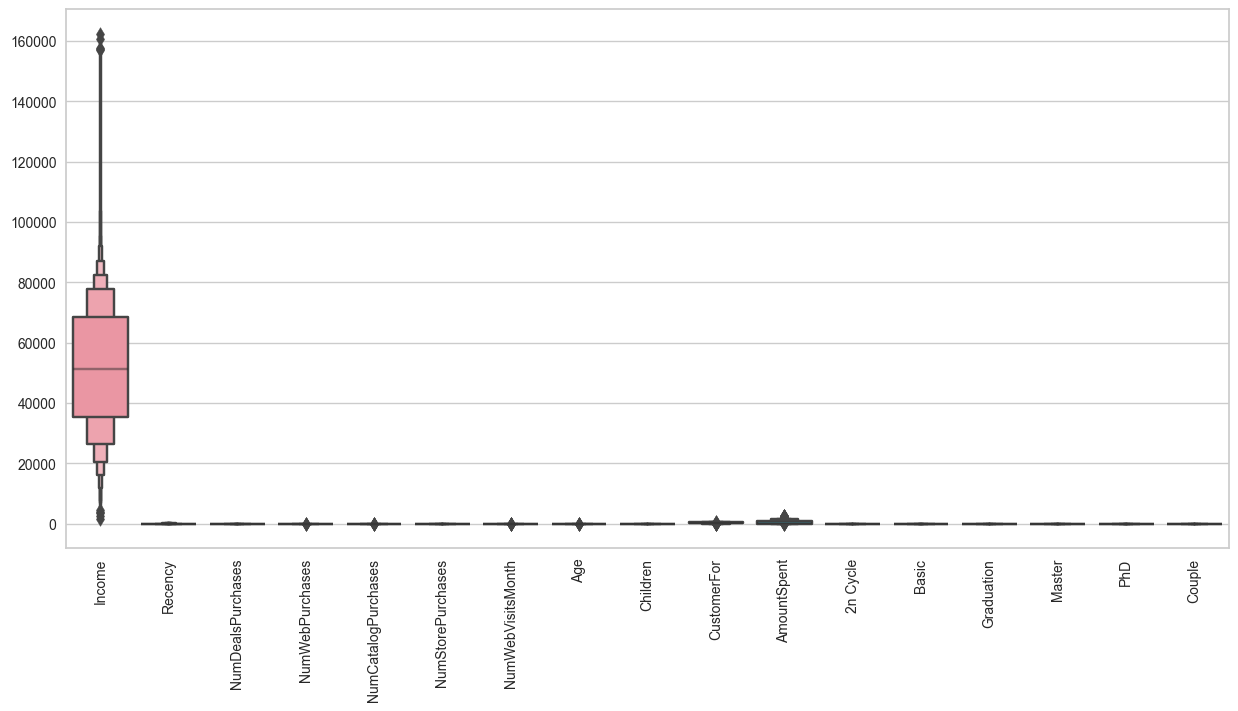

In [35]:
# Vẽ biểu đồ boxplot cho các feature
plt.figure(figsize=(15, 7))
plt.xticks(rotation=90)
sns.boxenplot(data=processed_df)

In [36]:
std_columns = ['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Children', 'CustomerFor', 'AmountSpent']

# Chuẩn hóa các feature đã chọn
scaler = StandardScaler()
processed_df[std_columns] = scaler.fit_transform(processed_df[std_columns])

<Axes: >

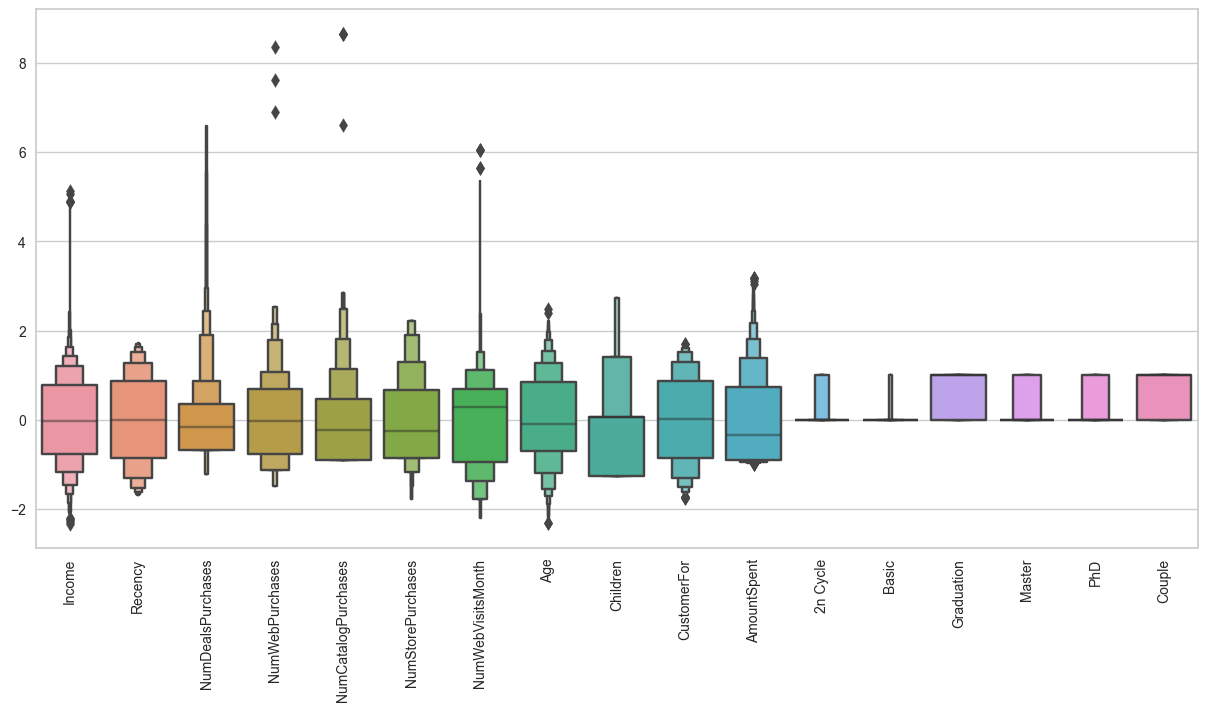

In [37]:
# Vẽ biểu đồ boxplot cho các feature
plt.figure(figsize=(15, 7))
plt.xticks(rotation=90)
sns.boxenplot(data=processed_df)

## 6, Thuật toán K-Means phương pháp chọn số cụm K

### 6.1 Giới thiệu thuật toán K-Means
- **K-Means** là thuật toán học máy không giám sát (tức là chưa biến nhãn đầu ra), thường được sử dụng khi muốn phân các điểm dữ liệu có sự tương đồng với nhau vào thành các cụm. Đây là thuật toán rất đơn giản và được sử dụng phổ biến rộng rãi, nó phân các điểm dữ liệu đầu vào thành **K cụm** (K được xác định trước). 
- **WCSS** viết tắt cho *Within-Cluster Sum of Squares* - là thước đo để đánh giá chất lượng của việc phân cụm. **WCSS** đo lường mức độ gần gũi hoặc chặt chẽ của các cụm bằng cách tính tổng bình phương khoảng cách giữa mỗi điểm dữ liệu và trọng tâm được gán của nó trong từng cụm.
- Mục tiêu của thuật toán là tối thiểu đại lượng **WCSS**. Giá trị **WCSS** nhỏ hơn tức là các điểm dữ liệu gần với trung tâm cụm của nó thuộc về hơn, dẫn đến các cụm gần gũi và tách biệt tốt hơn. Một cách để tối thiểu hóa đại lượng **WCSS** là chọn K (số cụm) sao cho **WCSS** giảm mà không dẫn đến overfitting.

### 6.2 Phương pháp chọn số K

**Phương pháp sử dụng:** `Elbow (khuỷu tay)`

In [38]:
# Tính WCSS khi số cụm là 1 đến 10
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++')
  kmeans.fit(processed_df)
  wcss.append(kmeans.inertia_)

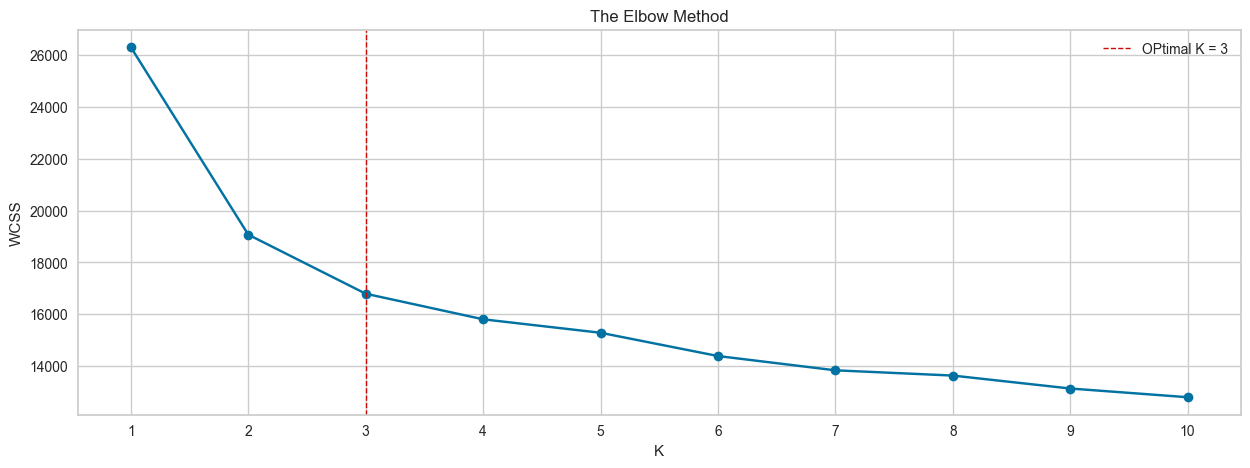

In [39]:
plt.figure(figsize=(15,5))

plt.xticks(np.arange(1,11,1))
plt.plot(range(1,11), wcss, marker='o', linestyle='-')

plt.title("The Elbow Method")
plt.xlabel("K")
plt.ylabel("WCSS")

plt.axvline(x=3, color='r', linestyle='--', linewidth=1, label='OPtimal K = 3')
plt.legend()

plt.show()

`Nhận xét:` Có thể thấy số cụm tối ưu là K = 3

- `Silhouette Score`: tính toán độ tương đồng của một điểm dữ liệu đối với cụm mà nó thuộc và độ khác biệt của nó so với các cụm khác.
- Giá trị silhouette score có thể nằm trong khoảng từ **-1 đến 1**. Một silhouette score gần 1 cho biết dữ liệu được phân chia tốt, trong khi một silhouette score gần -1 cho biết dữ liệu được phân chia không tốt. Nếu silhouette score gần 0, điều đó chỉ ra rằng các cụm có sự chồng chéo.

In [40]:
# Số lần chạy lại thuật toán KMeans
q_number = 10
silhouette_scores = []

# Tính silhouette score cho mỗi số cụm từ 2 đến K_max
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    sum = 0
    for q in range(q_number):
        kmeans.fit(processed_df)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(processed_df, labels)
        sum += silhouette_avg
    avg = sum / q_number
    silhouette_scores.append(avg)

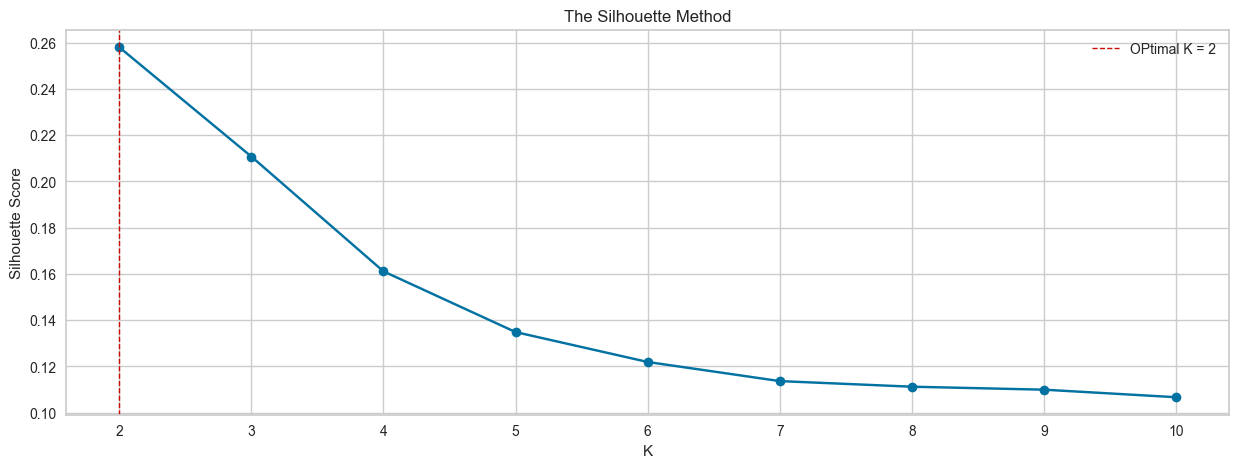

In [41]:
plt.figure(figsize=(15,5))

plt.xticks(np.arange(2,11,1))
plt.plot(range(2,11), silhouette_scores, marker='o', linestyle='-')

plt.title("The Silhouette Method")
plt.xlabel("K")
plt.ylabel("Silhouette Score")

plt.axvline(x=2, color='r', linestyle='--', linewidth=1, label='OPtimal K = 2')
plt.legend()

plt.show()

## 7, Huấn luyện mô hình và thực hiện phân cụm

In [42]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(processed_df)
raw_df2['Cluster'] = kmeans.labels_

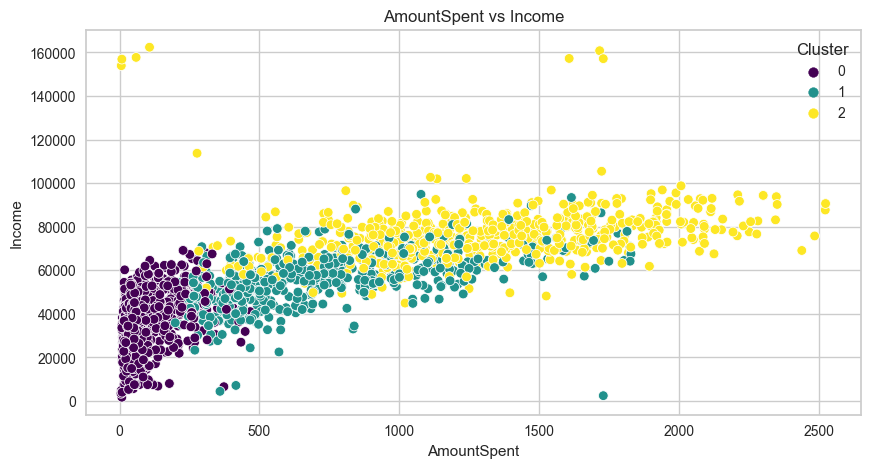

In [54]:
# Figure settings
plt.figure(figsize=(10,5))

# Create a scatter plot using Seaborn
sns.scatterplot(x='AmountSpent', y='Income', hue="Cluster", data=raw_df2, palette='viridis')

# Set the title and labels
plt.title('AmountSpent vs Income')
plt.xlabel('AmountSpent')
plt.ylabel('Income')

# Show the plot
plt.show()

`Nhận xét 1:` chúng ta thấy rằng có 3 cụm như  sau
- Cụm 0: Nhóm thu nhập thấp, chi tiêu thấp
- Cụm 1: Nhóm thu nhập trung bình, chi tiêu trung bình
- Cụm 2: Nhóm thu nhập cao, chi tiêu cao

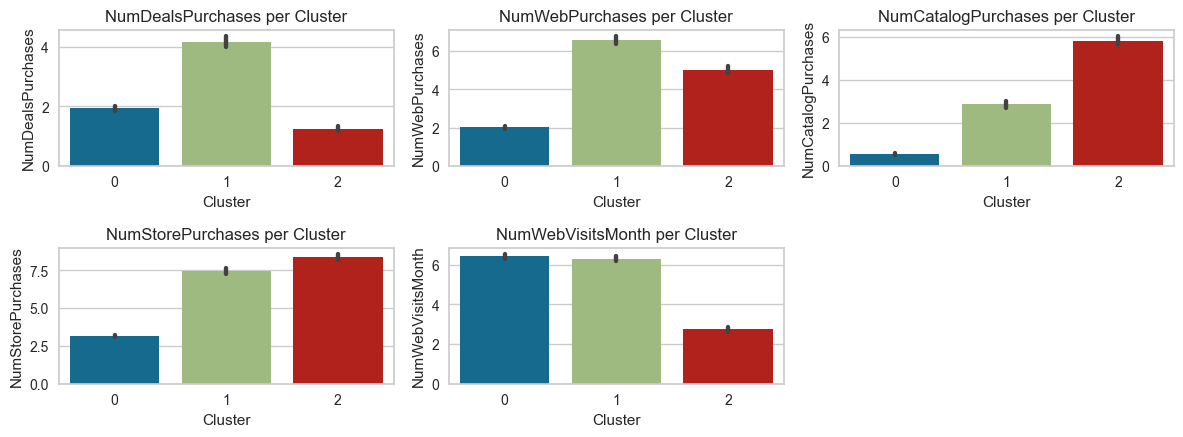

In [44]:
columnList = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

plt.figure(figsize=(12, 15))

for i, column in enumerate(columnList):
    plt.subplot(len(raw_df2.columns)//3 + 1, 3, i+1,)  # Create subplots
    sns.barplot(x='Cluster', y=column, data=raw_df2)
    plt.title(column + " per Cluster")
    plt.tight_layout()
plt.show()

`Nhận xét 2:`
- Nhóm thu nhập thấp, chi tiêu thấp (cụm 0) có lượt truy cập vào website nhiều nhất nhưng số lượt mua của nhóm này không nhiều bằng 2 nhóm còn lại nên chúng ta có thể bỏ qua nhóm này khi quảng cáo sản phẩm
- Nhóm thu nhập trung bình, chi tiêu trung bình (cụm 1) có số lượt truy cập vào website nhiều và lượng mua hàng ở cửa hàng và qua website cũng nhiều
- Nhóm thu nhập cao, chi tiêu cao (cụm 2) có xu hướng mua hàng trực tiếp ở store và theo danh mục, có một số lượng người nhỏ mua hàng qua website

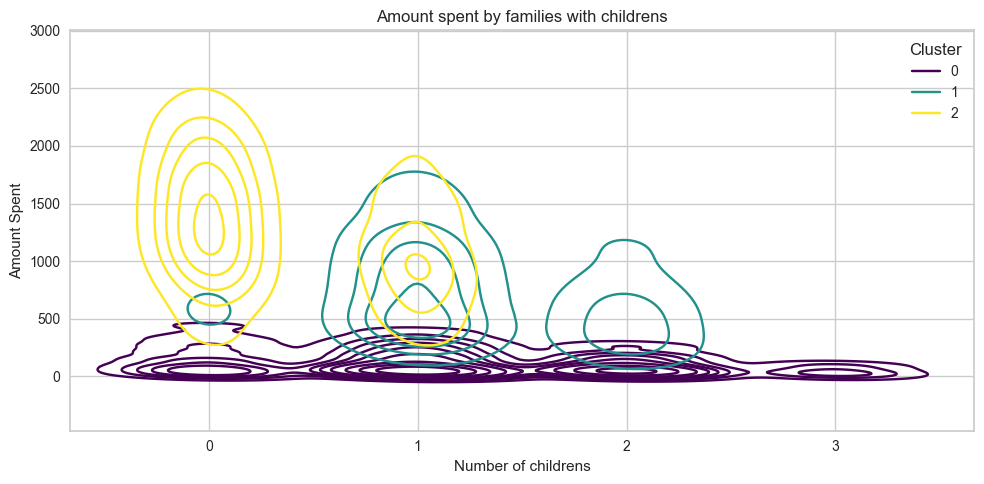

In [47]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0,4,1))
sns.kdeplot(x='Children', y='AmountSpent', hue="Cluster", data=raw_df2, palette='viridis')

# Set the title and labels
plt.title('Amount spent by families with childrens')
plt.xlabel('Number of childrens')
plt.ylabel('Amount Spent')

plt.tight_layout()

`Nhận xét 3:`
- Nhóm thu nhập cao, chi tiêu cao có từ 0-1 con nhưng chủ yếu là không có con
- Nhóm thu nhập trung bình, chi tiêu trung bình có từ 1-2 con
- Nhóm thu thu nhập thấp có xu hướng có nhiều con hơn 2 nhóm còn lại

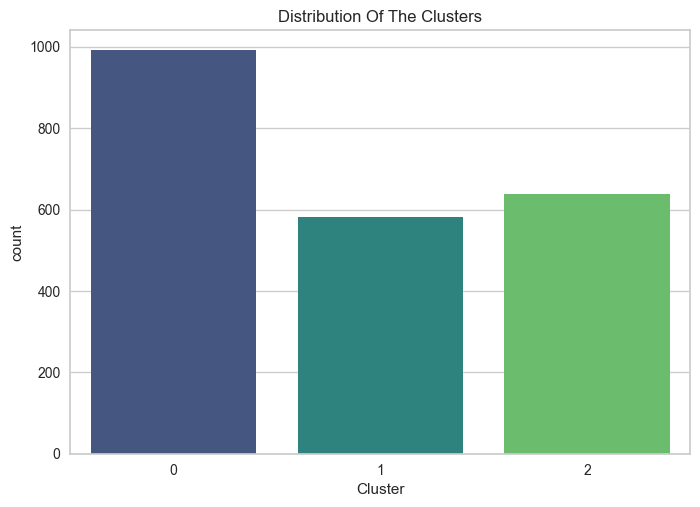

In [48]:
#Plotting countplot of clusters
pl = sns.countplot(x=raw_df2["Cluster"], palette='viridis')
pl.set_title("Distribution Of The Clusters")
plt.show()

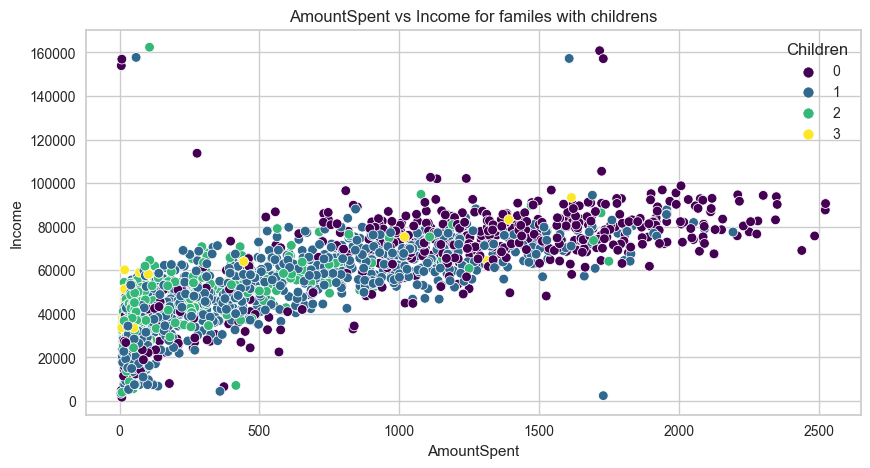

In [55]:
# Figure settings
plt.figure(figsize=(10,5))

# Create a scatter plot using Seaborn
sns.scatterplot(x='AmountSpent', y='Income', hue="Children", data=raw_df2, palette='viridis')

# Set the title and labels
plt.title('AmountSpent vs Income for familes with childrens')
plt.xlabel('AmountSpent')
plt.ylabel('Income')

# Show the plot
plt.show()